In [2]:
import jax
print("JAX path:", jax.__file__)

JAX path: /Users/yuxin/miniconda3/lib/python3.12/site-packages/jax/__init__.py


## Presettings

In [3]:
## load module
import bstpp
import numpy as np
import numpyro 
import numpyro.distributions as dist
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install torch
import torch
np.random.seed(999)

/Users/yuxin/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from bstpp.main import LGCP_Model, Hawkes_Model, load_Chicago_Shootings, load_Boko_Haram

In [5]:
from shapely.geometry import box

In [6]:
## set working directory
import os
os.chdir("/Users/yuxin/Dropbox/DDDI/Illegal-Dumping")

## Preprocessing data

In [7]:
## load data
litter_24 = gpd.read_file('data/311/2024/public_cases_fc.shp')

## filter data
illegal_dumping_24 = litter_24[litter_24['service_na'] == "Illegal Dumping"]

In [8]:
## prepare boundry of philly like "boundry"
# load shapefile of PA in 2024 from ACS
PA = gpd.read_file('data/tl_2024_42_bg/tl_2024_42_bg.shp')

# restrict to philly
philly = PA[PA['COUNTYFP'] == "101"]

# add a small buffer to the boundaries
philly_buffered = philly.buffer(0.01)  # Add 0.01 degrees buffer

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_7677/1378685729.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  philly_buffered = philly.buffer(0.01)  # Add 0.01 degrees buffer


In [9]:
# filter points in philly
illegal_dumping_24 = illegal_dumping_24.sjoin(philly, predicate='within')

/Users/yuxin/miniconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:2391: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


### Jittering time

#### 1. Ramdomly jitter

In [ ]:

# jitter the time
illegal_dumping_24['jittered_time'] = illegal_dumping_24['requested_'] + \
    pd.to_timedelta(np.random.uniform(0, 86400, len(illegal_dumping_24)), unit='s')

# get coordinates from the geometry
coords = pd.DataFrame({
    'x': illegal_dumping_24.geometry.centroid.x,
    'y': illegal_dumping_24.geometry.centroid.y
})

# calculate time difference in days from the minimum date
min_time = illegal_dumping_24['jittered_time'].min()
time_diff = (illegal_dumping_24['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)
illegal_dumping_24['time_diff'] = (illegal_dumping_24['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)

locs_s_rd = pd.DataFrame({'X': coords['x'], 'Y': coords['y'], 'T': time_diff})

# Reset index and ensure proper column names
locs_s_rd = locs_s_rd.reset_index(drop=True)

# Make sure columns are properly named and data types are correct
locs_s_rd = pd.DataFrame({'X': coords['x'], 'Y': coords['y'], 'T': time_diff})
locs_s_rd = locs_s_rd.astype({'X': float, 'Y': float, 'T': float})

#### 2. Normally distributed time jittering (within days)

In [ ]:
# Using std of 1 hour (3600 seconds) for more distinct time points
illegal_dumping_24['jittered_time'] = illegal_dumping_24['requested_'] + \
    pd.to_timedelta(np.random.normal(loc=43200, scale=3600, size=len(illegal_dumping_24)), unit='s')

# get coordinates from the geometry
coords = pd.DataFrame({
    'x': illegal_dumping_24.geometry.centroid.x,
    'y': illegal_dumping_24.geometry.centroid.y
})

# calculate time difference in days from the minimum date
min_time = illegal_dumping_24['jittered_time'].min()
time_diff = (illegal_dumping_24['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)
illegal_dumping_24['time_diff'] = time_diff  # Simplified this line

# Create locs_s DataFrame (simplified to avoid repetition)
locs_s = pd.DataFrame({
    'X': coords['x'].astype(float),
    'Y': coords['y'].astype(float),
    'T': time_diff.astype(float)
})

#### 3. Time-based jittering (within days)

In [10]:
# Create time windows throughout the day
time_windows = [
    (0, 14400),      # 12am-4am
    (14400, 28800),  # 4am-8am
    (28800, 43200),  # 8am-12pm
    (43200, 57600),  # 12pm-4pm
    (57600, 72000),  # 4pm-8pm
    (72000, 86400)   # 8pm-12am
]

# Calculate how many points to assign to each window
points_per_window = len(illegal_dumping_24) // len(time_windows)
remaining_points = len(illegal_dumping_24) % len(time_windows)

# Generate jittered times
jittered_times = []
for i, (start, end) in enumerate(time_windows):
    # Add extra points to first few windows if we have remainder
    n_points = points_per_window + (1 if i < remaining_points else 0)
    # Generate uniform random times within this window
    window_times = np.random.uniform(start, end, n_points)
    jittered_times.extend(window_times)

# Shuffle the times to avoid any ordering
np.random.shuffle(jittered_times)

# Apply the jittered times
illegal_dumping_24['jittered_time'] = illegal_dumping_24['requested_'] + \
    pd.to_timedelta(jittered_times, unit='s')

# get coordinates from the geometry
coords = pd.DataFrame({
    'x': illegal_dumping_24.geometry.centroid.x,
    'y': illegal_dumping_24.geometry.centroid.y
})

# calculate time difference in days from the minimum date
min_time = illegal_dumping_24['jittered_time'].min()
time_diff = (illegal_dumping_24['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)
illegal_dumping_24['time_diff'] = time_diff

# Create locs_s DataFrame
locs_s = pd.DataFrame({
    'X': coords['x'].astype(float),
    'Y': coords['y'].astype(float),
    'T': time_diff.astype(float)
})

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_7677/2919669896.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'x': illegal_dumping_24.geometry.centroid.x,
/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_7677/2919669896.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'y': illegal_dumping_24.geometry.centroid.y


In [11]:
# Calculate time differences between consecutive points
locs_s = locs_s.sort_values('T')
time_diffs = locs_s['T'].diff().fillna(0)

# Create jitter that's proportional to the time differences
# Use a fraction of the time difference as the jitter amount
jitter_fraction = 0.1  # Jitter will be 10% of the time difference
jitter = np.random.normal(0, time_diffs * jitter_fraction)

# Apply the jitter
locs_s['T'] = locs_s['T'] + jitter

# Ensure no negative times
locs_s['T'] = locs_s['T'].clip(lower=0)

# Sort by time again
locs_s = locs_s.sort_values('T')

# Reset index
locs_s = locs_s.reset_index(drop=True)

In [13]:
locs_s.to_csv('output/311_24_jitter.csv', index=False)


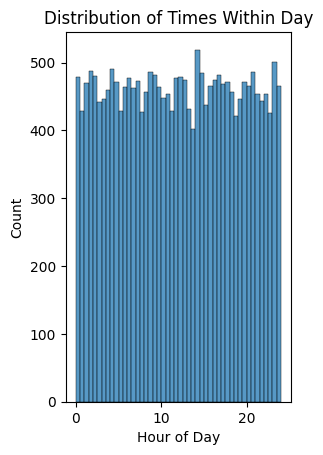

In [11]:
# Plot daily distribution
plt.subplot(1, 2, 1)
hours = illegal_dumping_24['jittered_time'].dt.hour + \
        illegal_dumping_24['jittered_time'].dt.minute/60
sns.histplot(data=hours, bins=48)  # Increased bins for smoother visualization
plt.title('Distribution of Times Within Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.savefig('output/daily_time_distribution.png', 
           dpi=450,  # High resolution
           bbox_inches='tight')  # Tight layout

### Setting time window

In [14]:
locs_s_60 = locs_s[locs_s['T'] <= 60]
print(f"Number of rows: {locs_s_60.shape[0]}")
print(f"Number of columns: {locs_s_60.shape[1]}")

Number of rows: 3128
Number of columns: 3


In [13]:
locs_s_180 = locs_s[locs_s['T'] <= 180]
print(f"Number of rows: {locs_s_180.shape[0]}")
print(f"Number of columns: {locs_s_180.shape[1]}")

Number of rows: 10659
Number of columns: 3


In [21]:
locs_s_300 = locs_s[locs_s['T'] <= 300]
print(f"Number of rows: {locs_s_300.shape[0]}")
print(f"Number of columns: {locs_s_300.shape[1]}")

Number of rows: 19145
Number of columns: 3


In [52]:
print(f"Number of rows: {locs_s.shape[0]}")
print(f"Number of columns: {locs_s.shape[1]}")

Number of rows: 22156
Number of columns: 3


## Model fitting

In [16]:
## Cox-Hawkes model
# a_0 = baseline log-intensity
# alpha = magnitute of excitation
# bate = temporal trigger param
# sigmax_2 = spatial trigger param
model = Hawkes_Model(locs_s_60,#spatiotemporal points
                     philly,#philly boundaries
                     60,#Time frame 
                     True,#use Cox as background
#                     spatial_cov=data['covariates'],#spatial covariate matrix
#                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(0,2), 
                     # alpha = dist.Beta(20,60),#set priors
                     alpha = dist.Beta(2,2),
                     # beta=dist.HalfNormal(2.0),
                     beta=dist.HalfNormal(1.0),
                     sigmax_2=dist.HalfNormal(0.25)
                    )



/Users/yuxin/BSTPP/bstpp/main.py:114: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


[DEBUG] set_window called with:
  window type: <class 'float'> value: 12.0
  spatial_window type: <class 'float'> value: 0.25
[DEBUG] aligned_difference_pairs called with:
  t type: <class 'numpy.ndarray'> dtype: float64 shape: (3128,)
  x type: <class 'numpy.ndarray'> dtype: float64 shape: (3128,)
  y type: <class 'numpy.ndarray'> dtype: float64 shape: (3128,)
  window type: <class 'float'> value: 12.0
  spatial_window type: <class 'float'> value: 0.25
[set_window] Temporal window set to: 12.0
[set_window] Number of events: 3128
[set_window] Number of pairs: 1113775
[set_window] Max t_diff in pairs: 11.99998756412639
[set_window] Min t_diff in pairs: 1.4597327472110067e-05
[set_window] All t_diff <= window: True
[set_window] All t_diff > 0: True
[set_window] Spatial window set to: 0.25
[set_window] Max spatial distance: 0.2499997466802597
[set_window] Min spatial distance: 0.0
[set_window] All spatial distances <= window: True


  0%|          | 0/5000 [00:00<?, ?it/s]2025-05-28 16:43:23.747571: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.1624 = s32[1113775,1]{1,0} slice(s32[1113775,2]{1,0} %constant.207), slice={[0:1113775], [0:1]}, metadata={op_name="jit(body_fn)/jit(main)/slice[start_indices=(0, 0) limit_indices=(1113775, 1) strides=None]" source_file="/Users/yuxin/BSTPP/bstpp/inference_functions.py" source_line=120}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-05-28 16:43:26.248156: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.505612s
Constant folding a

Number of posterior samples: 1000
Number of pairs: 1113775
coords shape: (1113775, 2)

SVI elapsed time: 79.91989398002625


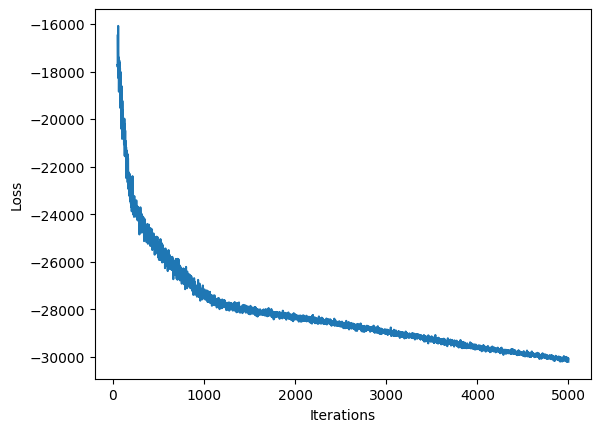

In [17]:
model.set_window(window = 12, spatial_window= 0.25)
model.run_svi(lr=0.005,num_steps=5000) # less interations and bigger learning rate

In [33]:
model.log_expected_likelihood(locs_s)

1.5692608290016568e+25

In [34]:
model.expected_AIC()

-3.141001107572403e+22

### Parameters

0.8353545665740967

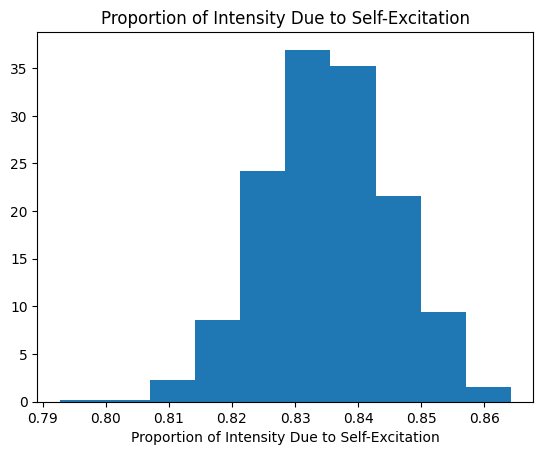

In [42]:
model.plot_prop_excitation()


,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,0.737824,0.045669,1.0,0.645860,0.819799
beta,0.142176,0.115930,1.0,0.030771,0.413459
sigmax_2,0.039357,0.011261,1.0,0.022538,0.063419


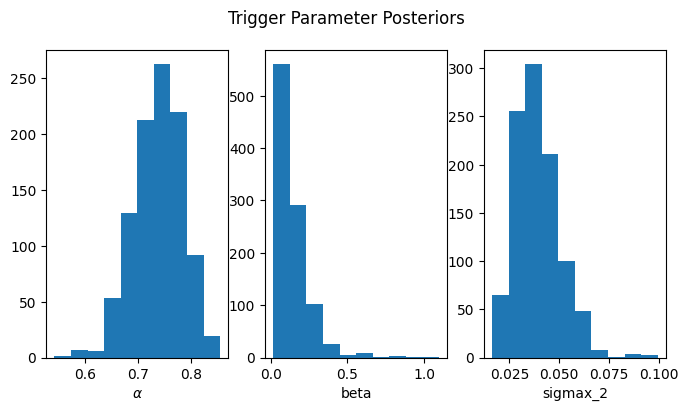

In [36]:
model.plot_trigger_posterior(trace=False)


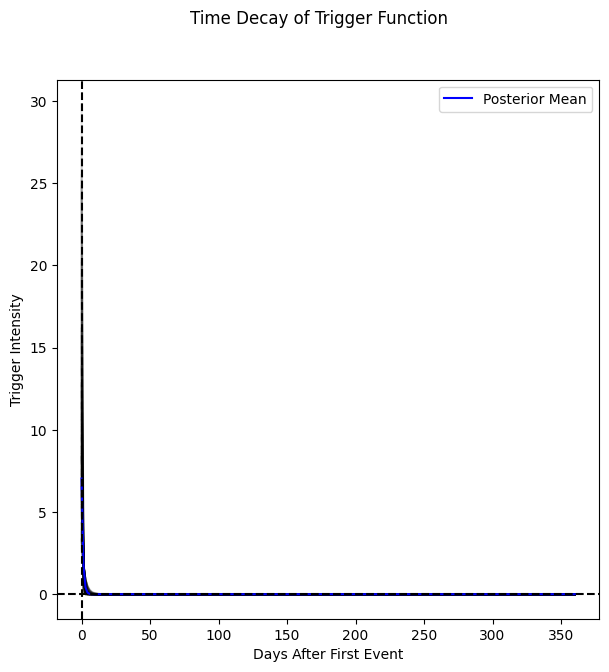

<Figure size 640x480 with 0 Axes>

In [37]:
model.plot_trigger_time_decay()
plt.gcf()

# Show the plot
plt.show()

### Visualizations

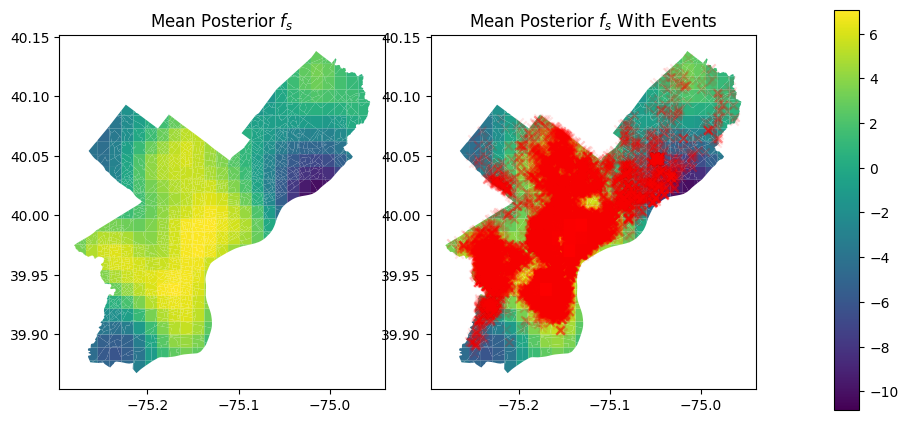

In [38]:
model.plot_spatial(include_cov=False)
plt.gcf().savefig('output/spatial_trigger.png', 
                 dpi=450,
                 bbox_inches='tight')

# Show the plot
plt.show()

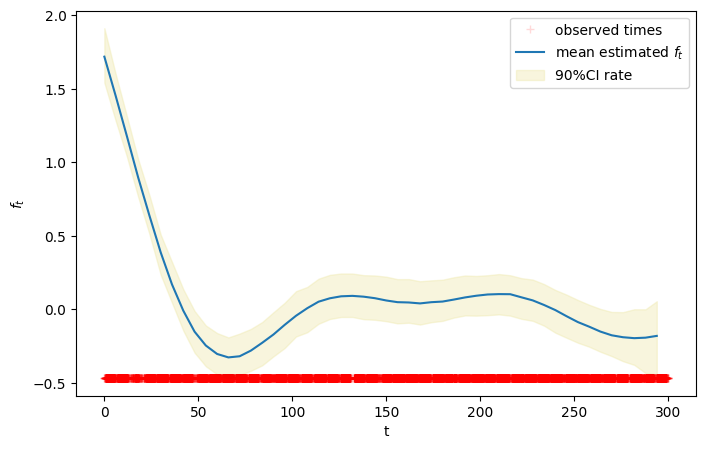

In [30]:
model.plot_temporal()
plt.gcf().savefig('output/temporal_trigger.png', 
                 dpi=450,
                 bbox_inches='tight')

# Show the plot
plt.show()

## Tacony Creek Park

### preprocessing

In [24]:
## import shapfile of the water system  in philly
water_system = gpd.read_file('parks/TTFWatershed/TTFWatershed.shp')

In [41]:
# check original crs
#print(water_system.crs)

# change crs to 4326
water_system = water_system.to_crs(epsg=4326)
philly = philly.to_crs(epsg=4326)
print(water_system.crs)


EPSG:4326


In [26]:
# get the total bounds of the original polygon
minx, miny, maxx, maxy = water_system.total_bounds

# set buffer
buffer = 0.005
minx -= buffer
maxx += buffer
miny -= buffer
maxy += buffer

# compute the side length of the square
side = max(maxx - minx, maxy - miny)

# center of the original bounds
center_x = (minx + maxx) / 2
center_y = (miny + maxy) / 2

# create new square bounds
square_minx = center_x - side / 2
square_maxx = center_x + side / 2
square_miny = center_y - side / 2
square_maxy = center_y + side / 2

# create square as a shapely box
square = box(square_minx, square_miny, square_maxx, square_maxy)

# make it a GeoDataFrame
square_gdf = gpd.GeoDataFrame(geometry=[square], crs=water_system.crs)

<Axes: >

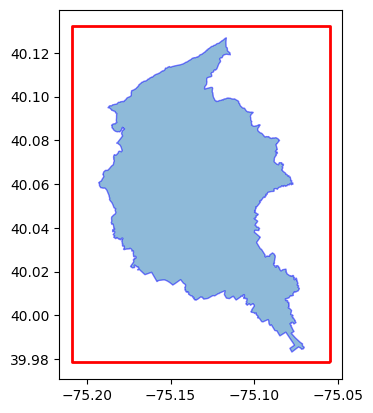

In [27]:
# plot
ax = water_system.plot(edgecolor='blue', alpha=0.5)
square_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

In [28]:
# filter points in the box
illegal_dumping_tacony = illegal_dumping_24.sjoin(square_gdf, predicate='within')

In [29]:
# Create time windows throughout the day
time_windows = [
    (0, 14400),      # 12am-4am
    (14400, 28800),  # 4am-8am
    (28800, 43200),  # 8am-12pm
    (43200, 57600),  # 12pm-4pm
    (57600, 72000),  # 4pm-8pm
    (72000, 86400)   # 8pm-12am
]

# Calculate how many points to assign to each window
points_per_window = len(illegal_dumping_tacony) // len(time_windows)
remaining_points = len(illegal_dumping_tacony) % len(time_windows)

# Generate jittered times
jittered_times = []
for i, (start, end) in enumerate(time_windows):
    # Add extra points to first few windows if we have remainder
    n_points = points_per_window + (1 if i < remaining_points else 0)
    # Generate uniform random times within this window
    window_times = np.random.uniform(start, end, n_points)
    jittered_times.extend(window_times)

# Shuffle the times to avoid any ordering
np.random.shuffle(jittered_times)

# Apply the jittered times
illegal_dumping_tacony['jittered_time'] = illegal_dumping_tacony['requested_'] + \
    pd.to_timedelta(jittered_times, unit='s')

# get coordinates from the geometry
coords = pd.DataFrame({
    'x': illegal_dumping_tacony.geometry.centroid.x,
    'y': illegal_dumping_tacony.geometry.centroid.y
})

# calculate time difference in days from the minimum date
min_time = illegal_dumping_tacony['jittered_time'].min()
time_diff = (illegal_dumping_tacony['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)
illegal_dumping_tacony['time_diff'] = time_diff

# Create locs_s DataFrame
locs_s = pd.DataFrame({
    'X': coords['x'].astype(float),
    'Y': coords['y'].astype(float),
    'T': time_diff.astype(float)
})

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_3295/4076496229.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'x': illegal_dumping_tacony.geometry.centroid.x,
/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_3295/4076496229.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'y': illegal_dumping_tacony.geometry.centroid.y


In [30]:
# Calculate time differences between consecutive points
locs_s = locs_s.sort_values('T')
time_diffs = locs_s['T'].diff().fillna(0)

# Create jitter that's proportional to the time differences
# Use a fraction of the time difference as the jitter amount
jitter_fraction = 0.1  # Jitter will be 10% of the time difference
jitter = np.random.normal(0, time_diffs * jitter_fraction)

# Apply the jitter
locs_s['T'] = locs_s['T'] + jitter

# Ensure no negative times
locs_s['T'] = locs_s['T'].clip(lower=0)

# Sort by time again
locs_s = locs_s.sort_values('T')

# Reset index
locs_s = locs_s.reset_index(drop=True)

In [31]:
locs_s_180 = locs_s[locs_s['T'] <= 180]
print(f"Number of rows: {locs_s_180.shape[0]}")
print(f"Number of columns: {locs_s_180.shape[1]}")

Number of rows: 4867
Number of columns: 3


### modeling

In [32]:
## Cox-Hawkes model
# a_0 = baseline log-intensity
# alpha = magnitute of excitation
# bate = temporal trigger param
# sigmax_2 = spatial trigger param
model = Hawkes_Model(locs_s_180,#spatiotemporal points
                     square_gdf,#philly boundaries
                     180,#Time frame 
                     True,#use Cox as background
#                     spatial_cov=data['covariates'],#spatial covariate matrix
#                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(0,2), 
                     # alpha = dist.Beta(20,60),#set priors
                     alpha = dist.Beta(2,2),
                     # beta=dist.HalfNormal(2.0),
                     beta=dist.HalfNormal(1.0),
                     sigmax_2=dist.HalfNormal(0.25)
                    )


/Users/yuxin/BSTPP/bstpp/main.py:114: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


[DEBUG] set_window called with:
  window type: <class 'float'> value: 12.0
  spatial_window type: <class 'float'> value: 0.25
[DEBUG] aligned_difference_pairs called with:
  t type: <class 'numpy.ndarray'> dtype: float64 shape: (4867,)
  x type: <class 'numpy.ndarray'> dtype: float64 shape: (4867,)
  y type: <class 'numpy.ndarray'> dtype: float64 shape: (4867,)
  window type: <class 'float'> value: 12.0
  spatial_window type: <class 'float'> value: 0.25
[set_window] Temporal window set to: 12.0
[set_window] Number of events: 4867
[set_window] Number of pairs: 1773045
[set_window] Max t_diff in pairs: 11.999997235236286
[set_window] Min t_diff in pairs: 4.081660499366535e-06
[set_window] All t_diff <= window: True
[set_window] All t_diff > 0: True
[set_window] Spatial window set to: 0.25
[set_window] Max spatial distance: 0.24999995529651642
[set_window] Min spatial distance: 0.0
[set_window] All spatial distances <= window: True


  0%|          | 0/5000 [00:00<?, ?it/s]2025-05-28 16:46:22.397592: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  %slice.1624 = s32[1773045,1]{1,0} slice(s32[1773045,2]{1,0} %constant.207), slice={[0:1773045], [0:1]}, metadata={op_name="jit(body_fn)/jit(main)/slice[start_indices=(0, 0) limit_indices=(1773045, 1) strides=None]" source_file="/Users/yuxin/BSTPP/bstpp/inference_functions.py" source_line=120}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-05-28 16:46:24.002279: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.606843s
Constant folding a

Number of posterior samples: 1000
Number of pairs: 1773045
coords shape: (1773045, 2)

SVI elapsed time: 175.2390100955963


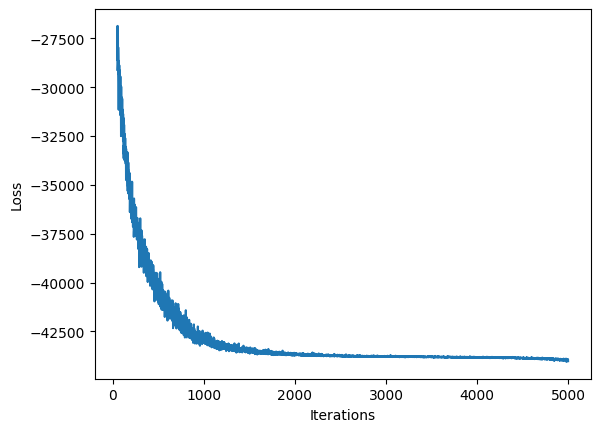

In [33]:
model.set_window(window = 12, spatial_window= 0.25)
model.run_svi(lr=0.005,num_steps=5000) # less interations and bigger learning rate

### results

In [34]:
model.log_expected_likelihood(locs_s_180)

22063.845703125

In [35]:
model.expected_AIC()

-43981.12890625

0.7885202169418335

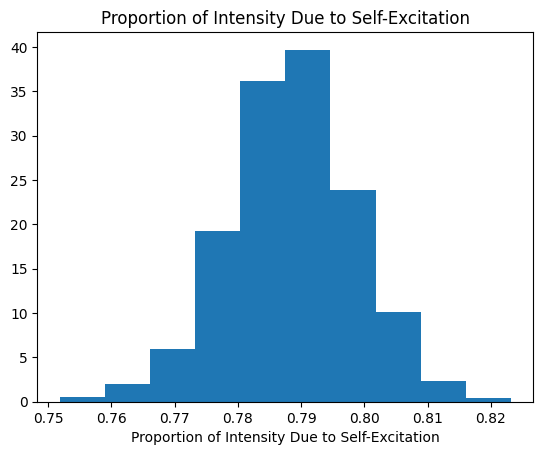

In [36]:
model.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,0.842716,0.012221,1.0,0.818198,0.865709
beta,0.579814,0.043052,1.0,0.496754,0.667995
sigmax_2,0.002392,0.000195,1.0,0.002024,0.002810


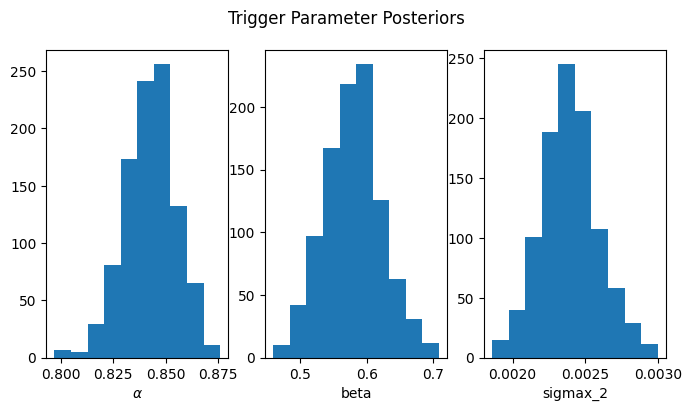

In [37]:
model.plot_trigger_posterior(trace=False)


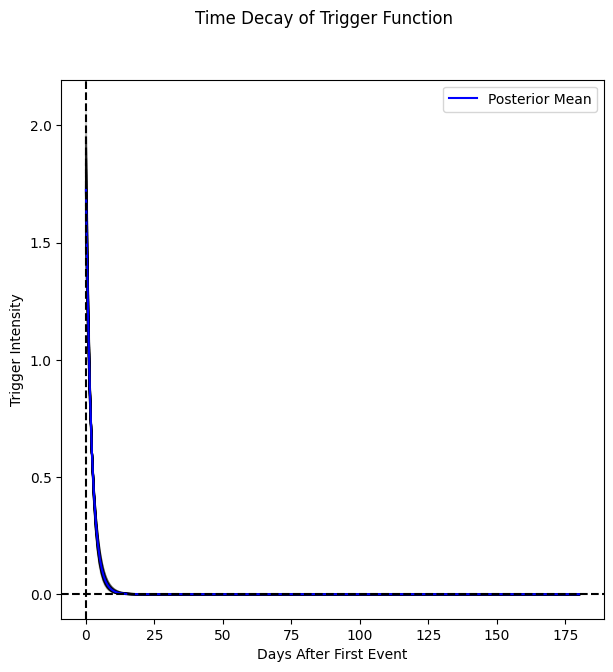

<Figure size 640x480 with 0 Axes>

In [38]:
model.plot_trigger_time_decay()
plt.gcf()

# Show the plot
plt.show()

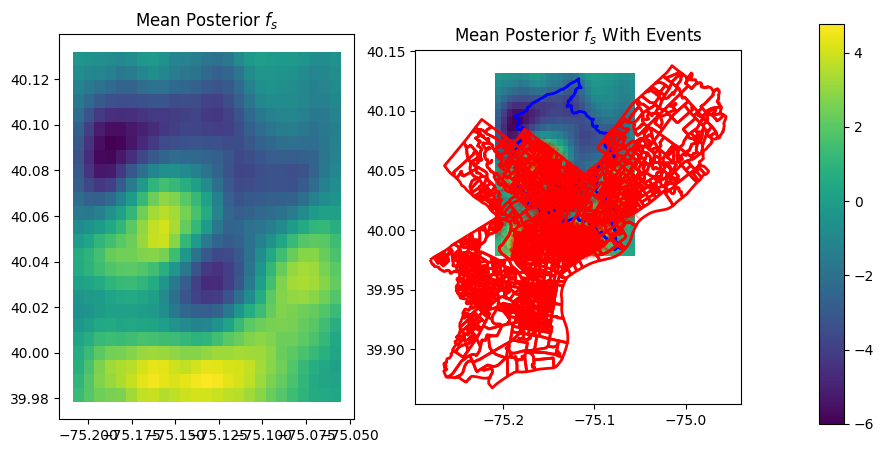

In [42]:
model.plot_spatial(include_cov=False)

# Get all axes in the figure
fig = plt.gcf()
axs = fig.get_axes()

# Try plotting on the second subplot (with events)
water_system.plot(ax=axs[1], edgecolor='blue', facecolor='none', linewidth=2)
philly.plot(ax=axs[1], edgecolor='red', facecolor='none', linewidth=2)


# Save and show
plt.savefig('output/spatial_trigger_tacony.png', dpi=450, bbox_inches='tight')
plt.show()

In [47]:
philly_border = gpd.read_file('data/City_Limits/City_Limits.shp')
print(philly_border.crs)

EPSG:4326


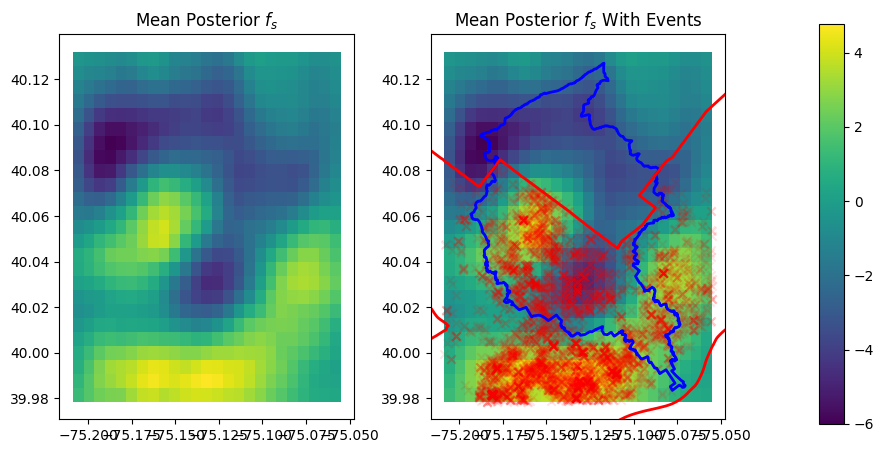

In [48]:
model.plot_spatial(include_cov=False)

# Get all axes in the figure
fig = plt.gcf()
axs = fig.get_axes()

# Match limits from left subplot
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

# Try plotting on the second subplot (with events)
water_system.plot(ax=axs[1], edgecolor='blue', facecolor='none', linewidth=2)
philly_border.plot(ax=axs[1], edgecolor='red', facecolor='none', linewidth=2)

# Set the same limits on the right subplot
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

# Save and show
plt.savefig('output/spatial_trigger_tacony.png', dpi=450, bbox_inches='tight')
plt.show()


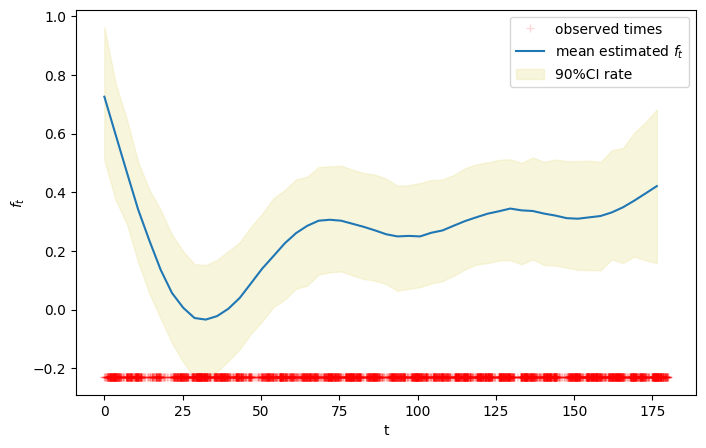

In [35]:
model.plot_temporal()
plt.gcf().savefig('output/temporal_trigger_tacony.png', 
                 dpi=450,
                 bbox_inches='tight')

# Show the plot
plt.show()

## PPR Data

In [8]:
## load ppr data
ppr = gpd.read_file('parks/PPR/PPR_Properties.geojson')

In [15]:
tacony = ppr[ppr["PARENT_NAME"] == "Tacony Creek Park"]
tacony.head(10)
## ONJECTID for Tacony Creek Park is 10
## Juniata Golf Club is included in Park&Recreation'a map, ID is 64

,OBJECTID,PUBLIC_NAME,PARENT_NAME,NESTED,OFFICIAL_NAME,LABEL,ALIAS,DPP_ASSET_ID,ADDRESS_911,ZIP_CODE,...,PPR_OPS_DISTRICT,COUNCIL_DISTRICT,POLICE_DISTRICT,CITY_SCALE_MAPS,LOCAL_SCALE_MAPS,PROGRAM_SITES,COMMENTS,Shape__Area,Shape__Length,geometry
9,10,Tacony Creek Park,Tacony Creek Park,N,Tacony Creek Park,Tacony Creek Park,Brookwood Park,1961,None,19120,...,3,7;8;9,2;15;24;25;35,Y,Y,N,None,1.385039e+06,19006.357810,"MULTIPOLYGON (((-75.11086 40.0467, -75.11065 4..."
21,22,Lauretha Vaird Fields,Tacony Creek Park,Y,None,Vaird,Tabor Rams Club;Lauretha Vaird Boys and Girls ...,1890,4800 WHITAKER AVE,19120,...,3,7,25,Y,Y,N,None,4.358373e+04,858.843004,"POLYGON ((-75.11347 40.02332, -75.11344 40.023..."
25,26,Garland and Bingham Fields,Tacony Creek Park,Y,None,Garland and Bingham,Tabor and Garland Play Area,1368,620 GARLAND ST,19120,...,3,9,2,Y,Y,N,None,2.407785e+04,825.642883,"POLYGON ((-75.10919 40.03233, -75.10924 40.032..."
26,27,Hammond and Nedro Fields,Tacony Creek Park,Y,None,Hammond and Nedro,None,1866,5901 HAMMOND AVE,19120,...,3,9,35,Y,Y,N,None,2.793747e+04,773.909743,"POLYGON ((-75.11574 40.04074, -75.11562 40.040..."
63,64,Juniata Golf Club,Tacony Creek Park,Y,Juniata Golf Club,Juniata Golf Club,,348,1391 E CAYUGA ST,19124,...,3,7,15;24,Y,Y,N,None,6.350435e+05,4652.887761,"POLYGON ((-75.10138 40.02081, -75.1016 40.0203..."
109,110,Joseph A Ferko Playground,Tacony Creek Park,Y,Joseph A. Ferko Playground,Ferko,Juniata Park,1854,1101 E CAYUGA ST,19124,...,3,7,24,Y,Y,Y,Juniata Boys and Girls Club leases the eastern...,7.274218e+04,1580.764808,"POLYGON ((-75.10679 40.01572, -75.10674 40.015..."


<Axes: >

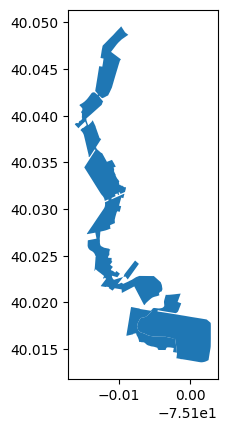

In [16]:
filtered_tacony = tacony[tacony["OBJECTID"].isin([10, 64])]
filtered_tacony.plot()

In [ ]:
fairmount= ppr[ppr["PARENT_NAME"].str.contains("Fairmount", case=False, na=False)]
fairmount.head()
## west and east fiarmount park OBJECT ID: 7 & 9

,OBJECTID,PUBLIC_NAME,PARENT_NAME,NESTED,OFFICIAL_NAME,LABEL,ALIAS,DPP_ASSET_ID,ADDRESS_911,ZIP_CODE,...,PPR_OPS_DISTRICT,COUNCIL_DISTRICT,POLICE_DISTRICT,CITY_SCALE_MAPS,LOCAL_SCALE_MAPS,PROGRAM_SITES,COMMENTS,Shape__Area,Shape__Length,geometry
6,7,West Fairmount Park,West Fairmount Park,N,West Fairmount Park,West Fairmount Park,None,1714,None,19131,...,5,3;4,16;19,Y,Y,N,None,7.152695e+06,70633.241489,"MULTIPOLYGON (((-75.1973 40.00761, -75.19725 4..."
8,9,East Fairmount Park,East Fairmount Park,N,East Fairmount Park,East Fairmount Park,,1713,None,19121,...,5,4,5;9;22;39,Y,Y,N,None,3.112516e+06,34217.692967,"MULTIPOLYGON (((-75.20034 40.01085, -75.20035 ..."
18,19,Sedgley Woods Disc Golf Course,East Fairmount Park,Y,None,Sedgley Woods,,3013,3400 RESERVOIR DR,19121,...,5,4,22,Y,Y,N,None,1.458032e+05,1661.313189,"POLYGON ((-75.19151 39.97949, -75.19191 39.979..."
23,24,Chamounix Tennis Courts,West Fairmount Park,Y,None,Chamounix Tennis,,1827,3601 CHAMOUNIX DR,19131,...,5,4,16,N,Y,N,None,2.877461e+04,1281.847817,"POLYGON ((-75.20364 39.99823, -75.20354 39.998..."
24,25,Smith Memorial Playground and Playhouse,East Fairmount Park,Y,None,Smith Memorial,,1955,3418 SMITH MEMORIAL DR,19121,...,5,4,22,Y,Y,N,None,3.166781e+04,730.793018,"POLYGON ((-75.19654 39.98146, -75.19649 39.981..."


In [ ]:
cobbscreek = ppr[ppr['PARENT_NAME'].str.contains("Cobbs Creek", case=False, na=False)]
cobbscreek.head(20)
## not sure about the interested object, keep all

,OBJECTID,PUBLIC_NAME,PARENT_NAME,NESTED,OFFICIAL_NAME,LABEL,ALIAS,DPP_ASSET_ID,ADDRESS_911,ZIP_CODE,...,PPR_OPS_DISTRICT,COUNCIL_DISTRICT,POLICE_DISTRICT,CITY_SCALE_MAPS,LOCAL_SCALE_MAPS,PROGRAM_SITES,COMMENTS,Shape__Area,Shape__Length,geometry
16,17,Whitby Avenue Playground,Cobbs Creek Park,Y,None,Whitby,,1372,1300 COBBS CREEK PKY,19143,...,8,3,12,Y,Y,N,None,3.891584e+04,949.454742,"POLYGON ((-75.2394 39.94188, -75.23887 39.9421..."
19,20,Robert Wilson III Park,Cobbs Creek Park,Y,Robert Wilson III Park,Wilson,61st and Baltimore Ave Playground,3454,6100 BALTIMORE AVE,19143,...,8,3,12,Y,Y,N,1911 Ordinance assigned to Department of Rec,8.015188e+03,360.391789,"POLYGON ((-75.24677 39.94344, -75.24663 39.943..."
20,21,Rufus O Williams Memorial Playground,Cobbs Creek Park,Y,Rufus O. Williams Memorial Playground,R Williams,Cobbs Creek Playground,2128,700 COBBS CREEK PKY,19143,...,8,3,18,Y,Y,N,None,2.641343e+04,817.250366,"POLYGON ((-75.25008 39.95121, -75.25005 39.951..."
56,57,Cobbs Creek Golf Course,Cobbs Creek Park,Y,Cobbs Creek Golf Course,Cobbs Creek Golf,Karakung Golf Course;Olde Golf Course,993,7900 LANSDOWNE AVE,19151,...,8,4,19,Y,Y,N,Located in Cobbs Creek Park. Closed for Renova...,2.229840e+06,12669.227838,"POLYGON ((-75.27558 39.97723, -75.27555 39.977..."
81,82,Carroll Park (Cobbs Creek),Cobbs Creek Park,Y,None,Carroll (Cobbs Creek),Price Park,3098,7800 CITY AVE,19151,...,8,N/A,N/A,Y,Y,N,Edited boundaries per October 1928 ordinance (...,2.040839e+05,2504.987107,"POLYGON ((-75.28147 39.97492, -75.2817 39.9752..."
136,137,Johnny Sample Recreation Center,Cobbs Creek Park,Y,Johnny Sample Recreation Center,Sample,Cobbs Creek Recreation Center and Pool,1836,250 S 63RD ST,19139,...,8,3,18,Y,Y,Y,None,4.663522e+04,1396.189322,"POLYGON ((-75.2488 39.9591, -75.24788 39.95899..."
142,143,Samuel Rose Recreation Center,Cobbs Creek Park,Y,Samuel Rose Recreation Center,Rose,Overbrook Park,1944,1225 N 75TH ST,19151,...,8,4,19,Y,Y,N,None,5.082116e+04,932.258064,"POLYGON ((-75.26064 39.97257, -75.26098 39.972..."
177,178,William T Granahan Playground,Cobbs Creek Park,Y,William T. Granahan Playground,Granahan,None,1864,6532 CALLOWHILL ST,19151,...,8,4,19,Y,Y,Y,None,3.661969e+04,1032.553699,"MULTIPOLYGON (((-75.25183 39.96957, -75.25183 ..."
431,432,Cobbs Creek Park,Cobbs Creek Park,Y,Cobbs Creek Park,Cobbs Creek Park,None,3056,None,19143,...,8,2;3;4,12;18;19,Y,Y,N,1911 Ordinance assigned portion near 60th and ...,2.399213e+06,36071.269379,"MULTIPOLYGON (((-75.24779 39.96181, -75.24778 ..."
445,446,Cobbs Creek Community Environmental Center,Cobbs Creek Park,Y,None,Cobbs Environ Center,Cobbs Creek EEC;Cobbs Creek Environmental Educ...,1835,700 COBBS CREEK PKWY,19143,...,8,3,18,Y,Y,Y,None,1.000279e+04,597.832117,"POLYGON ((-75.24934 39.95164, -75.24935 39.951..."


In [30]:
mifflin = ppr[ppr["PARENT_NAME"].str.contains("Mifflin")]
mifflin.head()
## Mifflin Square ID, 208

,OBJECTID,PUBLIC_NAME,PARENT_NAME,NESTED,OFFICIAL_NAME,LABEL,ALIAS,DPP_ASSET_ID,ADDRESS_911,ZIP_CODE,...,PPR_OPS_DISTRICT,COUNCIL_DISTRICT,POLICE_DISTRICT,CITY_SCALE_MAPS,LOCAL_SCALE_MAPS,PROGRAM_SITES,COMMENTS,Shape__Area,Shape__Length,geometry
86,87,Fort Mifflin,Fort Mifflin,N,Fort Mifflin,Ft Mifflin,Fort Mifflin Historical Site,1267,4800 FORT MIFFLIN RD,19153,...,8,2,12,Y,Y,N,None,277734.304688,3600.285706,"MULTIPOLYGON (((-75.21591 39.87122, -75.21594 ..."
207,208,Mifflin Square,Mifflin Square,N,None,Mifflin,,126,500 WOLF ST,19148,...,7,1,3,Y,Y,N,None,28736.800781,671.921971,"POLYGON ((-75.15591 39.91882, -75.15592 39.918..."


<Axes: >

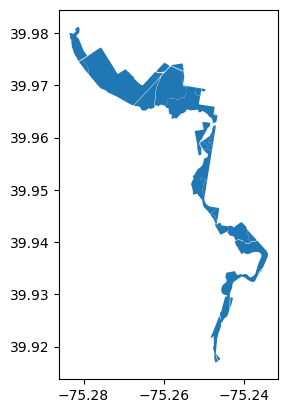

In [26]:
ccpark = cobbscreek[cobbscreek['OBJECTID'].isin([432])]
cobbscreek.plot()

## Failed: modify resolution: within function 

In [ ]:
# new model: set n_t and n_xy
model = Hawkes_Model(locs_s_60,#spatiotemporal points
                     philly,#philly boundaries
                     60,#Time frame 
                     True,#use Cox as background
#                     spatial_cov=data['covariates'],#spatial covariate matrix
#                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(0,2), 
                     # alpha = dist.Beta(20,60),#set priors
                     alpha = dist.Beta(2,2),
                     # beta=dist.HalfNormal(2.0),
                     beta=dist.HalfNormal(1.0),
                     sigmax_2=dist.HalfNormal(0.25)
                    )

## Falied: Modify resolution: change root code of the module

### Reset n_xy from 25 to 50

In [ ]:
model = Hawkes_Model(locs_s_60,#spatiotemporal points
                     philly,#philly boundaries
                     60,#Time frame 
                     True,#use Cox as background
#                     spatial_cov=data['covariates'],#spatial covariate matrix
#                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(0,2), 
                     # alpha = dist.Beta(20,60),#set priors
                     alpha = dist.Beta(2,2),
                     # beta=dist.HalfNormal(2.0),
                     beta=dist.HalfNormal(1.0),
                     sigmax_2=dist.HalfNormal(0.25)
                    )

In [ ]:
model.run_svi(lr=0.005,num_steps=5000) # less interations and bigger learning rate

In [ ]:
model.plot_trigger_time_decay()
plt.show()

In [ ]:
model.plot_temporal()
plt.show()

In [ ]:
model.plot_spatial(include_cov=False)